In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, exists
import numpy as np
import PIL
import matplotlib.pyplot as plt
from glob import glob
import cv2
from natsort import natsorted
import torch
import torchvision

import shared_utils as su

In [3]:
data_dir = "../data/datasets/pouring_dataset/"

image_dir = join(data_dir, "fakeB")
amask_dir = join(data_dir, "trainA_liquid_masks")
cup_mask_dir = join(data_dir, "trainA_cup_masks")

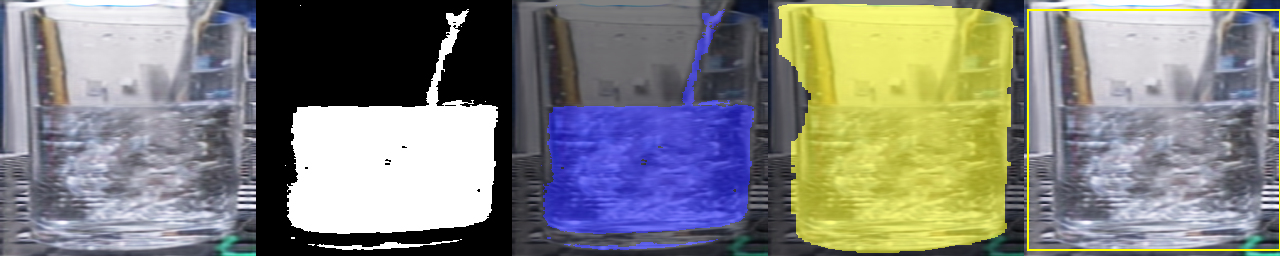

In [11]:
i = 3
imsize = (256, 256)

# Get raw image
image_path = join(image_dir, f"rgb_{i}.png")
assert exists(image_path)
image = PIL.Image.open(image_path)
image = image.resize(imsize)

# Get liquid mask
amask_path = join(amask_dir, f"liquid_mask_{i}.npy")
assert exists(amask_path)
amask = np.load(amask_path)
# Resize for SAM compatibility
amask = su.viz.resize_mask(amask)

# Get cup mask (to obtain bounding box)
cup_mask_path = join(cup_mask_dir, f"cup_mask_{i}.npy")
assert exists(cup_mask_path)
cup_mask = np.load(cup_mask_path)
# Resize for SAM compatibility
cup_mask = su.viz.resize_mask(cup_mask)
# Get bounding box from the segmentation map
cup_bbox = su.viz.mask_to_bounding_box(cup_mask, perturbation=10)

# Helpers for visualization
amask_pil = su.viz.alpha_mask_to_pil_image(amask, 0.95)
cup_mask_pil = su.viz.alpha_mask_to_pil_image(cup_mask, 0.45)
image_with_amask = su.viz.add_mask_on_image(image, amask_pil, color="blue")
image_with_cup_mask = su.viz.add_mask_on_image(image, cup_mask_pil, color="yellow")
image_with_cup_bbox = su.viz.add_bbox_on_image(image, cup_bbox, color="yellow")

su.viz.concat_images(
    [image, amask_pil, image_with_amask, image_with_cup_mask, image_with_cup_bbox]
)

### Dev code

In [5]:
gt_images = natsorted(glob(join(data_dir, "fakeB/*.png")))
mask_images = natsorted(glob(join(data_dir, "trainA/*.jpg")))

mask_dir = join(data_dir, "trainA_liquid_masks")
mask_paths = natsorted(glob(join(mask_dir, "*.npy")))

assert len(gt_images) == len(mask_images)
n_images = len(gt_images)

In [6]:
n_images

2231

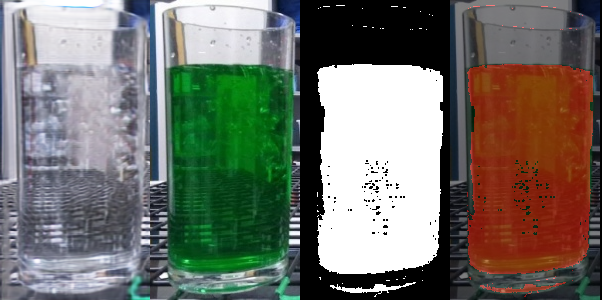

In [7]:
# i = np.random.randint(n_images)
i = 50

transp_img = PIL.Image.open(gt_images[i])
opaque_img = PIL.Image.open(mask_images[i])
mask = np.load(mask_paths[i])
mask[mask < 0.95] = 0.
mask_pil = PIL.Image.fromarray(np.clip(mask * 255., 0, 255).astype(np.uint8))
opaque_img_with_mask = su.viz.add_mask_on_image(opaque_img, mask_pil, color="red")

su.viz.concat_images(
    [transp_img, opaque_img, mask_pil, opaque_img_with_mask]
)